<a href="https://colab.research.google.com/github/LawTAGS/Deep-Learning-Classwork/blob/main/DL_AE_Denoising_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 183s 383ms/step - loss: 0.2434 - val_loss: 0.1143
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 373ms/step - loss: 0.1127 - val_loss: 0.1071
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 208s 386ms/step - loss: 0.1063 - val_loss: 0.1033
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 382ms/step - loss: 0.1030 - val_loss: 0.1010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 378ms/step - loss: 0.1011 - val_loss: 0.0995
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 382ms/step - loss: 0.0997 - val_loss: 0.0983
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 372ms/step - loss: 0.0989 - val_loss: 0.0974
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 174s 370ms/step - loss: 0.0980 - val_loss: 0.0968
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 372ms/step - loss: 0.0972 - val_loss: 0.0961
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 174s 370ms/step - loss: 0.0967 - val_loss: 0.0958
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step


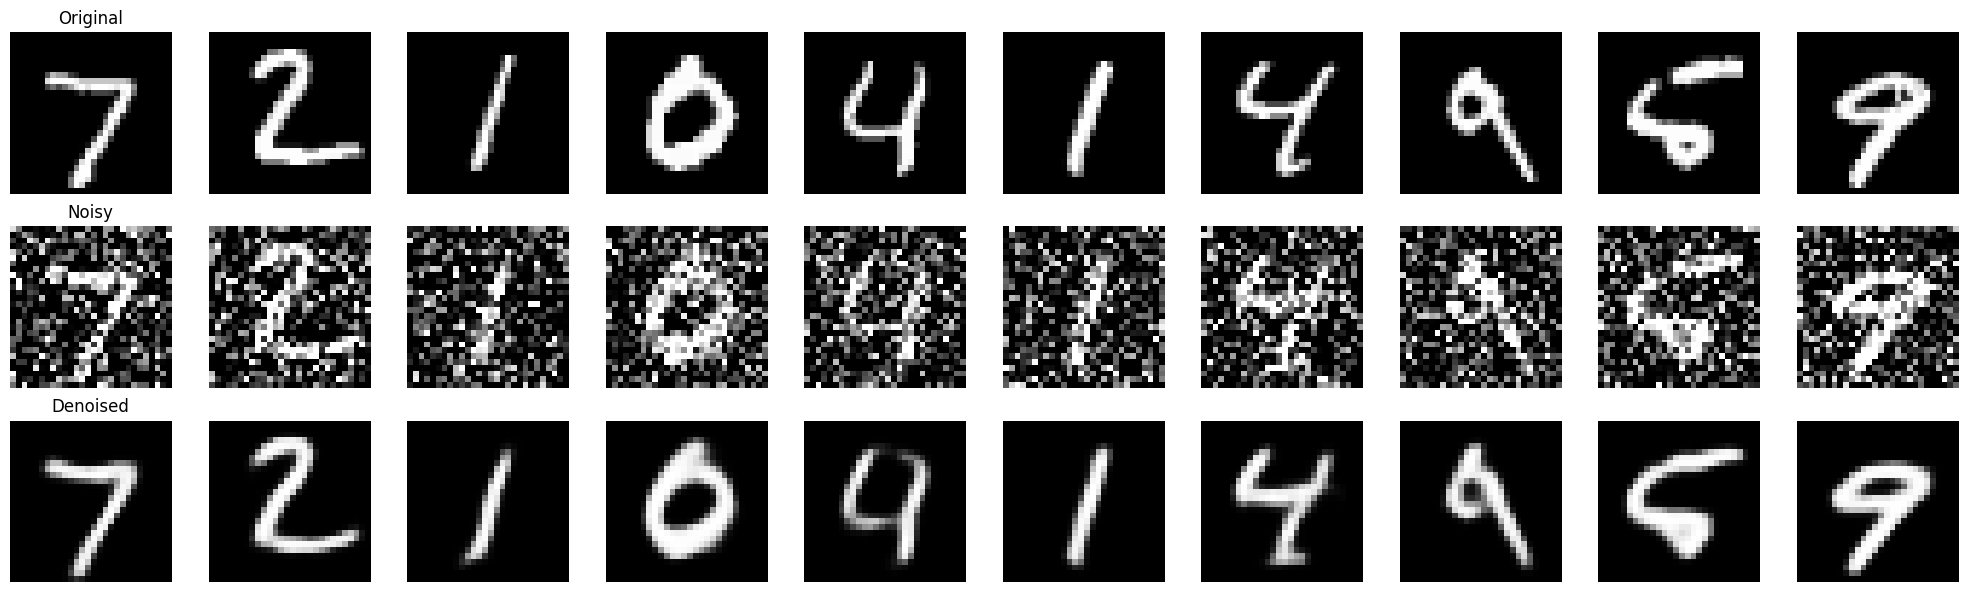

In [ ]:
import numpy as np                            # Numerical computing
import matplotlib.pyplot as plt               # Plotting library
import tensorflow as tf                       # TensorFlow core
from tensorflow.keras import layers, models   # Keras layers & models API
from tensorflow.keras.datasets import mnist   # MNIST dataset loader

# 1. Load MNIST and normalize pixel values to the [0,1] range
#    - x_train: training images, shape (60000, 28, 28)
#    - x_test : test images,     shape (10000, 28, 28)
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0   # convert to float32 and scale
x_test  = x_test.astype('float32')  / 255.0

# 2. Reshape to add the channel dimension for Conv2D layers
#    New shape: (N_samples, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test,  -1)

# 3. Create noisy versions of the images
noise_factor = 0.5
#    Add Gaussian noise then clip to keep pixel values in [0,1]
x_train_noisy = np.clip(
    x_train + noise_factor * np.random.normal(size=x_train.shape),
    0, 1
)
x_test_noisy = np.clip(
    x_test + noise_factor * np.random.normal(size=x_test.shape),
    0, 1
)

# 4. Build the denoising autoencoder model
input_img = layers.Input(shape=(28, 28, 1))      # Input placeholder for 28×28 grayscale

# --- Encoder: progressively downsample and encode features ---
x = layers.Conv2D(
    32,                 # 32 filters
    (3, 3),             # 3×3 kernel
    activation='relu',
    padding='same'      # same spatial dimensions
)(input_img)
x = layers.MaxPooling2D(
    (2, 2),             # 2×2 pooling
    padding='same'      # keep feature map size
)(x)                    # Now 14×14×32

x = layers.Conv2D(
    64,                 # 64 filters
    (3, 3),
    activation='relu',
    padding='same'
)(x)
encoded = layers.MaxPooling2D(
    (2, 2),
    padding='same'
)(x)                    # Encoded representation: 7×7×64

# --- Decoder: upsample back to the original image size ---
x = layers.Conv2D(
    64,
    (3, 3),
    activation='relu',
    padding='same'
)(encoded)
x = layers.UpSampling2D(
    (2, 2)
)(x)                    # Upsample to 14×14×64

x = layers.Conv2D(
    32,
    (3, 3),
    activation='relu',
    padding='same'
)(x)
x = layers.UpSampling2D(
    (2, 2)
)(x)                    # Upsample to 28×28×32

decoded = layers.Conv2D(
    1,                  # single-channel output
    (3, 3),
    activation='sigmoid',  # sigmoid for [0,1] output
    padding='same'
)(x)                    # Final output: 28×28×1

# 5. Instantiate the autoencoder: maps noisy input → denoised output
autoencoder = models.Model(input_img, decoded)

# 6. Compile the model
#    - optimizer: Adam
#    - loss: binary crossentropy (pixel-wise)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 7. Train the autoencoder on noisy→clean image pairs
#    - x_train_noisy: noisy inputs
#    - x_train      : ground-truth clean targets
#    - validation on test set of noisy→clean
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,                   # number of passes through the data
    batch_size=128,              # batch size for SGD
    shuffle=True,                # shuffle training data each epoch
    validation_data=(x_test_noisy, x_test)
)

# 8. Use the trained model to denoise the test images
decoded_imgs = autoencoder.predict(x_test_noisy)

# 9. Visualize a few examples: original, noisy, and denoised
n = 10  # number of images to display
plt.figure(figsize=(20, 6))

for i in range(n):
    # --- Original clean image ---
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Original')

    # --- Noisy input image ---
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Noisy')

    # --- Denoised (reconstructed) image ---
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Denoised')

plt.tight_layout()
plt.show()
